## Assignment 2 | Problem 1
The MNIST dataset can be directly imported from trusted cloud platforms and verified entries such as `tensorflow.org`. This data can then be loaded and preprocessed before classification training and testing.

A seed of `42` is set for reproducibility to keep a constant result.

Feature structure as described by TensorFlow:
```
FeaturesDict({
    'image': Image(shape=(28, 28, 1), dtype=uint8),
    'label': ClassLabel(shape=(), dtype=int64, num_classes=10),
})
```

Therefore, the label feature will be discarded as it is not required for the classification task.

In [23]:
import certifi
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Dense, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.utils import to_categorical

# Set seed for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Force HTTPS to use specific certificate for MNIST installation
os.environ['SSL_CERT_FILE'] = certifi.where()

# Load and preprocess MNIST
(x_train, _), (x_test, _) = mnist.load_data()

Neural networks perform better with small input values, where a range of 0-1 is better than a range of 0-255. Large input values cause large activations, which makes large gradients, and leads to unstable weight updates. As a result, the input values will be normalised to maintain a more accurate output and stable training.

The type conversion to float32 is to allow decimals for increased precision when normalising, where float32 is preferred over float64 for computational speed and hardware optimisation.

A channel value of 1 (for greyscale, as opposed to 3 for RGB) is appended at the end of the input vector to conform with the vector requirements for a CNN.

In [24]:
# Normalise and add channel dimension
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)

The problem statement requires that the MNIST dataset be split into thirds, where each third is rotated differently. 1/3 is left-rotated, 1/3 is right-rotated, and 1/3 not rotated. The train and test sets will be split into three equal parts with the rotations applied accordingly.

In [25]:
# Create rotation labels (0: none, 1: left, 2: right)
def apply_rotations(images):
    n = len(images)
    rotated = []
    labels = []

    # Split into thirds
    split = n // 3
    # No rotation
    rotated.append(images[:split])
    labels.extend([0] * split)
    # Left rotation (90° CCW)
    rotated.append(np.rot90(images[split:2*split], k=1, axes=(1, 2)))
    labels.extend([1] * split)
    # Right rotation (90° CW)
    rotated.append(np.rot90(images[2*split:3*split], k=-1, axes=(1, 2)))
    labels.extend([2] * split)

    return np.concatenate(rotated), np.array(labels)

In [26]:
x_train_rot, y_train_rot = apply_rotations(x_train)
x_test_rot, y_test_rot = apply_rotations(x_test)

In [27]:
# Split training into train/validation (80/20)
val_split = int(0.8 * len(x_train_rot))
x_val = x_train_rot[val_split:]
y_val = y_train_rot[val_split:]
x_train_final = x_train_rot[:val_split]
y_train_final = y_train_rot[:val_split]

In [28]:
# One-hot encode labels
y_train_final = to_categorical(y_train_final, 3)
y_val = to_categorical(y_val, 3)
y_test_rot = to_categorical(y_test_rot, 3)

In [29]:
# Build CNN
model = Sequential([
    InputLayer(shape=(28, 28, 1)),  # Explicit input layer
    Conv2D(32, (3,3), activation='relu'),
    MaxPooling2D((2,2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(3, activation='softmax')
])


In [30]:
# Configure SGD (as per SGD.pdf)
sgd = SGD(learning_rate=0.01, momentum=0.9)
model.compile(loss='categorical_crossentropy',
              optimizer=sgd,
              metrics=['accuracy'])


In [31]:
# Train CNN with explicit SGD iterations
history = model.fit(
    x_train_final, y_train_final,
    epochs=15,
    batch_size=64,  # Minibatch SGD
    validation_data=(x_val, y_val),
    verbose=1
)

Epoch 1/15
750/750 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.9573 - loss: 0.1238 - val_accuracy: 0.9933 - val_loss: 0.0251
Epoch 2/15
750/750 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.9875 - loss: 0.0363 - val_accuracy: 0.9905 - val_loss: 0.0283
Epoch 3/15
750/750 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.9908 - loss: 0.0263 - val_accuracy: 0.9733 - val_loss: 0.0723
Epoch 4/15
750/750 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.9924 - loss: 0.0212 - val_accuracy: 0.9672 - val_loss: 0.0909
Epoch 5/15
750/750 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.9927 - loss: 0.0193 - val_accuracy: 0.9509 - val_loss: 0.1365
Epoch 6/15
750/750 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.9944 - loss: 0.0161 - val_accuracy: 0.9397 - val_loss: 0.1723
Epoch 7/15
750/750 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.9953 - loss: 0.0131 - val_accuracy: 0.9433 - val_loss: 0.1576
Epoch 8/15
750/750 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.9965 - loss: 0.0103 - val_accuracy: 0.

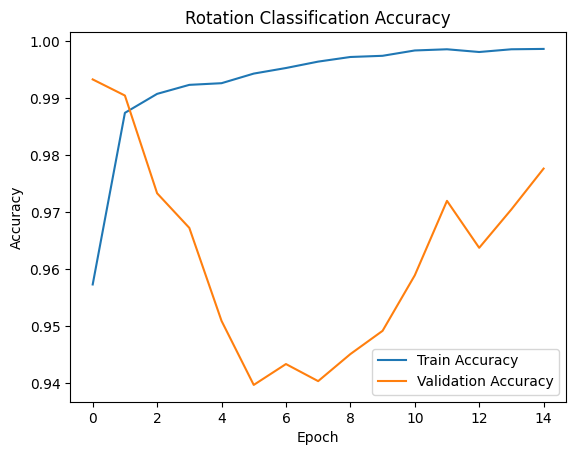

In [32]:
# Plot results
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Rotation Classification Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [33]:
# Evaluate on test set
test_loss, test_acc = model.evaluate(x_test_rot, y_test_rot, verbose=1)
print(f"\nTest Accuracy: {test_acc:.4f}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9938 - loss: 0.0233

Test Accuracy: 0.9938
